# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "chapter_16"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models", CHAPTER_ID)
LOGS_PATH = os.path.join(PROJECT_ROOT_DIR, "logs", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 16.1 文字RNNを使ったシェイクスピア風テキストの生成

- データ分割の例
- 0から14までの数値をwindow size5で2個ずらしながらまとめていく
- 最初の4つをX、1つずらして4つをYとしてデータを作成

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


2022-01-30 12:16:07.533509: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


### 16.1.1 訓練セットの作り方

In [4]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1130496/1115394 [==============================] - 0s 0us/step


In [5]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [6]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

- Tokenizerを使って文字を数値に変換する

In [7]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [8]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [9]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [10]:
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count

### 16.1.2 シーケンシャルデータセットの分割方法

In [12]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### 16.1.3 シーケンシャルデータセットの複数のウィンドウへの分割

In [13]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [14]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

In [16]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [17]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [18]:
dataset = dataset.prefetch(1)

In [19]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


### 16.1.4 文字RNNモデルの構築と訓練

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

Epoch 1/10
31368/31368 [==============================] - 8026s 256ms/step - loss: 1.4604
Epoch 2/10
31368/31368 [==============================] - 7978s 254ms/step - loss: 1.3556
Epoch 3/10
31368/31368 [==============================] - 7065s 225ms/step - loss: 1.3369
Epoch 4/10
31368/31368 [==============================] - 6223s 198ms/step - loss: 1.3278
Epoch 5/10
31368/31368 [==============================] - 7877s 251ms/step - loss: 1.3218
Epoch 6/10
31368/31368 [==============================] - 6688s 213ms/step - loss: 1.3177
Epoch 7/10
31368/31368 [==============================] - 9635s 307ms/step - loss: 1.3150
Epoch 8/10
31368/31368 [==============================] - 6189s 197ms/step - loss: 1.3126
Epoch 9/10
31368/31368 [==============================] - 6196s 197ms/step - loss: 1.3105
Epoch 10/10
31368/31368 [==============================] - 6234s 199ms/step - loss: 1.3086


### 16.1.5 文字RNNモデルの使い方

In [28]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [29]:
X_new = preprocess(["How are yo"])
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

In [27]:
tf.random.set_seed(42)
tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

### 16.1.6 シェイクスピア風の偽文書の生成

In [44]:
# 確率で選ばれるようにすることで、多様性が出るようにする
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [43]:
model(preprocess(["How are yo"]))[0, -1:, :]

<tf.Tensor: shape=(1, 39), dtype=float32, numpy=
array([[1.3782817e-05, 4.9199530e-06, 1.6791293e-04, 6.5346612e-05,
        8.1303888e-06, 3.2696607e-07, 3.4155782e-08, 2.5586796e-06,
        3.1187541e-05, 3.5413343e-04, 2.9682221e-06, 9.5898895e-07,
        2.0133903e-07, 9.9931097e-01, 1.0373039e-06, 6.5624528e-07,
        9.5302494e-06, 3.3755605e-06, 9.4307095e-09, 3.2183325e-06,
        7.6802706e-09, 2.0930509e-06, 3.4111189e-08, 1.0058047e-06,
        4.1352371e-07, 7.0602555e-06, 2.3807338e-06, 1.9729231e-07,
        1.3993091e-06, 3.4048232e-06, 3.4158131e-08, 3.0467902e-07,
        1.9948081e-10, 4.4070844e-10, 2.9673529e-08, 1.3899715e-07,
        6.2046417e-11, 5.8499468e-12, 4.5387353e-12]], dtype=float32)>

In [31]:
tf.random.set_seed(42)
next_char("How are yo", temperature=1)

'u'

In [34]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [35]:
tf.random.set_seed(42)
print(complete_text("t", temperature=0.2))

there is not the needless to her.

gremio:
what, i 


In [37]:
tf.random.set_seed(42)
print(complete_text("t", temperature=1))

to puilt her thund in so.

gremio:
my master, there


In [38]:
tf.random.set_seed(42)
print(complete_text("t", temperature=2))

ta,fullets me full darde.
nor no'erwiad, gly'- mess


### 16.1.7 ステートフルRNN

In [48]:
tf.random.set_seed(42)

In [49]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [50]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [53]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [54]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [55]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 57s 180ms/step - loss: 2.6186
Epoch 2/50
313/313 [==============================] - 58s 185ms/step - loss: 2.1767
Epoch 3/50
313/313 [==============================] - 57s 181ms/step - loss: 2.5134
Epoch 4/50
313/313 [==============================] - 57s 181ms/step - loss: 2.2904
Epoch 5/50
313/313 [==============================] - 57s 181ms/step - loss: 2.2198
Epoch 6/50
313/313 [==============================] - 57s 182ms/step - loss: 2.2328
Epoch 7/50
313/313 [==============================] - 57s 182ms/step - loss: 2.1230
Epoch 8/50
313/313 [==============================] - 56s 180ms/step - loss: 2.0851
Epoch 9/50
313/313 [==============================] - 57s 181ms/step - loss: 2.0752
Epoch 10/50
313/313 [==============================] - 56s 180ms/step - loss: 2.0287
Epoch 11/50
313/313 [==============================] - 57s 181ms/step - loss: 1.9954
Epoch 12/50
313/313 [==============================] - 57s 181ms/step - lo

- バッチサイズを変える場合は同様の構造のステートレスモデルを作り、重みをコピーする

In [56]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [57]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [58]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [61]:
tf.random.set_seed(42)
print(complete_text("t"))

tingcass us
a glace starves a maberls day.
why let 


# 16.2 感情分析 

In [62]:
tf.random.set_seed(42)

In [63]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17473536/17464789 [==============================] - 2s 0us/step


In [64]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1654784/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [65]:
import tensorflow_datasets as tfds
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

2022-01-26 21:08:32.475156: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-train.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-test.tfrecord...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling imdb_reviews-unsupervised.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /Users/mochidzukiyoshihiko/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [66]:
datasets.keys()

dict_keys([Split('train'), Split('test'), Split('unsupervised')])

In [68]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [69]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



2022-01-26 21:10:21.153887: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


- 前処理関数

In [70]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [76]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [77]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [82]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

- 最頻出な10,000語だけ使用する

In [83]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

- ルックアップテーブルを作る

In [84]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [85]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [87]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [88]:
train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [89]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


- モデル作成

In [90]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 59s 73ms/step - loss: 0.5305 - accuracy: 0.7281
Epoch 2/5
782/782 [==============================] - 55s 70ms/step - loss: 0.3459 - accuracy: 0.8549
Epoch 3/5
782/782 [==============================] - 55s 70ms/step - loss: 0.1934 - accuracy: 0.9314
Epoch 4/5
782/782 [==============================] - 54s 70ms/step - loss: 0.1360 - accuracy: 0.9503
Epoch 5/5
782/782 [==============================] - 57s 73ms/step - loss: 0.1032 - accuracy: 0.9634


### 16.2.1 マスキング

In [91]:
# 関数型API & マニュアルでマスキング
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 56s 68ms/step - loss: 0.5425 - accuracy: 0.7156
Epoch 2/5
782/782 [==============================] - 54s 70ms/step - loss: 0.3488 - accuracy: 0.8555
Epoch 3/5
782/782 [==============================] - 56s 71ms/step - loss: 0.1768 - accuracy: 0.9369
Epoch 4/5
782/782 [==============================] - 56s 71ms/step - loss: 0.1347 - accuracy: 0.9517
Epoch 5/5
782/782 [==============================] - 56s 72ms/step - loss: 0.1134 - accuracy: 0.9571


### 16.2.2 事前学習済みの埋め込みの再利用

In [95]:
tf.random.set_seed(42)

In [100]:
# キャッシュを永続化
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [97]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [98]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [99]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 1s 1ms/step - loss: 0.5461 - accuracy: 0.7267
Epoch 2/5
782/782 [==============================] - 1s 1ms/step - loss: 0.5130 - accuracy: 0.7495
Epoch 3/5
782/782 [==============================] - 1s 1ms/step - loss: 0.5081 - accuracy: 0.7532
Epoch 4/5
782/782 [==============================] - 1s 1ms/step - loss: 0.5047 - accuracy: 0.7540
Epoch 5/5
782/782 [==============================] - 1s 1ms/step - loss: 0.5018 - accuracy: 0.7566


# 16.3 ニューラル機械翻訳のためのエンコーダーデコーダ・ネットワーク

In [101]:
tf.random.set_seed(42)

In [102]:
vocab_size = 100
embed_size = 10

- 3.8でtensorflow_addonsを入れられない模様。。

In [105]:
# import tensorflow_addons as tfa

# encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
# decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

# embeddings = keras.layers.Embedding(vocab_size, embed_size)
# encoder_embeddings = embeddings(encoder_inputs)
# decoder_embeddings = embeddings(decoder_inputs)

# encoder = keras.layers.LSTM(512, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
# encoder_state = [state_h, state_c]

# sampler = tfa.seq2seq.sampler.TrainingSampler()

# decoder_cell = keras.layers.LSTMCell(512)
# output_layer = keras.layers.Dense(vocab_size)
# decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
#                                                  output_layer=output_layer)
# final_outputs, final_state, final_sequence_lengths = decoder(
#     decoder_embeddings, initial_state=encoder_state,
#     sequence_length=sequence_lengths)
# Y_proba = tf.nn.softmax(final_outputs.rnn_output)

# model = keras.models.Model(
#     inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
#     outputs=[Y_proba])

In [106]:
# model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [119]:
# X = np.random.randint(100, size=10*1000).reshape(1000, 10)
# Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
# X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
# seq_lengths = np.full([1000], 15)

In [ ]:
# history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

### 16.3.1 双方向RNN

In [120]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, None, 10)          660       
                                                                 
 bidirectional (Bidirectiona  (None, None, 20)         1320      
 l)                                                              
                                                                 
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### 16.3.2 ビームサーチ

# 16.4 注意機構

### 16.4.1 ビジュアル注意

### 16.4.2 必要なものは注意だけ：Transformerアーキテクチャ

- 位置埋め込み

In [4]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [5]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

- 位置埋め込み行列

Saving figure positional_embedding_plot


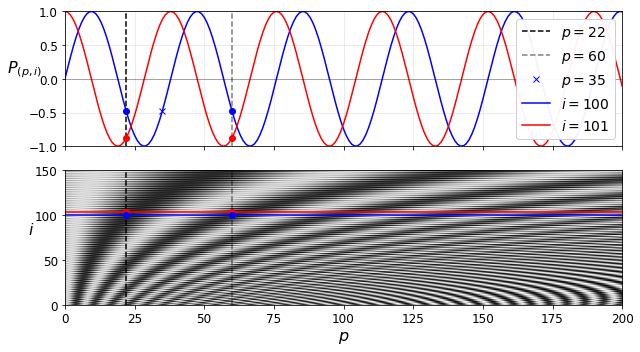

In [6]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

In [7]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

- （単純化した）Transformerの実装

In [8]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

In [9]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [10]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape

TensorShape([2, 50, 512])

# 16.5 言語モデルにおける最近のイノベーション

# 16.6 演習問題

### 16.6.8

In [14]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

- default_reber_grammar

In [15]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

- embedded_reber_grammar

In [17]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

- 文法を守らない文を生成する関数

In [22]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

- 文字をエンコード

In [19]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [20]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

- 50%で正しい文字列であるようなデータセットを生成する

In [21]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [23]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

In [24]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/Users/mochidzukiyoshihiko/miniforge3/envs/sandbox_py38/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:448: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/gru/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/gru/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/gru/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


313/313 [==============================] - 2s 4ms/step - loss: 0.6910 - accuracy: 0.5095 - val_loss: 0.6825 - val_accuracy: 0.5645
Epoch 2/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6678 - accuracy: 0.5659 - val_loss: 0.6635 - val_accuracy: 0.6105
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6504 - accuracy: 0.5766 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6347 - accuracy: 0.5980 - val_loss: 0.6224 - val_accuracy: 0.6445
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.6054 - accuracy: 0.6361 - val_loss: 0.5779 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.5414 - accuracy: 0.7093 - val_loss: 0.4695 - val_accuracy: 0.7795
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3902 - accuracy: 0.8324 - val_loss: 0.3289 - val_accuracy: 0.8640
Epoch 8/20
313/31

- テスト
- 最初の文は正しくなく、2番目の文は正しい。（正しい文には、最初から2番目の文字と最後から2番目の文字が一致する、というルールがある）

In [26]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.26%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.96%


### 16.6.9

- データセットの作成

In [31]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [32]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


- 文字リスト

In [33]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [34]:
OUTPUT_CHARS = "0123456789-"

In [35]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [36]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [37]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [38]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

#### seq2seq

In [39]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 6s 16ms/step - loss: 1.8160 - accuracy: 0.3486 - val_loss: 1.3729 - val_accuracy: 0.4918
Epoch 2/20
313/313 [==============================] - 5s 15ms/step - loss: 1.2136 - accuracy: 0.5572 - val_loss: 1.0488 - val_accuracy: 0.6169
Epoch 3/20
313/313 [==============================] - 5s 15ms/step - loss: 1.0898 - accuracy: 0.6108 - val_loss: 0.9107 - val_accuracy: 0.6672
Epoch 4/20
313/313 [==============================] - 5s 16ms/step - loss: 0.8676 - accuracy: 0.6904 - val_loss: 0.7380 - val_accuracy: 0.7237
Epoch 5/20
313/313 [==============================] - 5s 16ms/step - loss: 0.6048 - accuracy: 0.7686 - val_loss: 0.5252 - val_accuracy: 0.7905
Epoch 6/20
313/313 [==============================] - 5s 16ms/step - loss: 0.7182 - accuracy: 0.7431 - val_loss: 0.4879 - val_accuracy: 0.8245
Epoch 7/20
313/313 [==============================] - 5s 16ms/step - loss: 0.4996 - accuracy: 0.8253 - val_loss: 0.3628 - val_accuracy: 0.8669

In [40]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

- 予測

In [41]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [42]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


- 但し、このモデルでは最長の日付に合わせて学習しているので、短い日付の時はうまくいかないことがある

In [43]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [44]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-02-02
1789-01-14


- Paddingすることでこれに対処する

In [46]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

In [47]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

####  shifted targets to the decoder (teacher forcing)

In [48]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [49]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 6s 16ms/step - loss: 1.6826 - accuracy: 0.3733 - val_loss: 1.4075 - val_accuracy: 0.4687
Epoch 2/10
313/313 [==============================] - 5s 16ms/step - loss: 1.1949 - accuracy: 0.5538 - val_loss: 0.9048 - val_accuracy: 0.6625
Epoch 3/10
313/313 [==============================] - 5s 17ms/step - loss: 0.6519 - accuracy: 0.7649 - val_loss: 0.3803 - val_accuracy: 0.8787
Epoch 4/10
313/313 [==============================] - 5s 17ms/step - loss: 0.2202 - accuracy: 0.9455 - val_loss: 0.1193 - val_accuracy: 0.9786
Epoch 5/10
313/313 [==============================] - 5s 17ms/step - loss: 0.0700 - accuracy: 0.9929 - val_loss: 0.0399 - val_accuracy: 0.9991
Epoch 6/10
313/313 [==============================] - 5s 17ms/step - loss: 0.0786 - accuracy: 0.9874 - val_loss: 0.0242 - val_accuracy: 0.9996
Epoch 7/10
313/313 [==============================] - 5s 17ms/step - loss: 0.0173 - accuracy: 0.9998 - val_loss: 0.0149 - val_accuracy: 0.9999

In [50]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [51]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

#### TF-Addons's seq2seq

In [54]:
# import tensorflow_addons as tfa

# np.random.seed(42)
# tf.random.set_seed(42)

# encoder_embedding_size = 32
# decoder_embedding_size = 32
# units = 128

# encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
# decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

# encoder_embeddings = keras.layers.Embedding(
#     len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

# decoder_embedding_layer = keras.layers.Embedding(
#     len(OUTPUT_CHARS) + 2, decoder_embedding_size)
# decoder_embeddings = decoder_embedding_layer(decoder_inputs)

# encoder = keras.layers.LSTM(units, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
# encoder_state = [state_h, state_c]

# sampler = tfa.seq2seq.sampler.TrainingSampler()

# decoder_cell = keras.layers.LSTMCell(units)
# output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

# decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
#                                                  sampler,
#                                                  output_layer=output_layer)
# final_outputs, final_state, final_sequence_lengths = decoder(
#     decoder_embeddings,
#     initial_state=encoder_state)
# Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

# model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
#                            outputs=[Y_proba])
# optimizer = keras.optimizers.Nadam()
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
#                     validation_data=([X_valid, X_valid_decoder], Y_valid))

In [55]:
# predict_date_strs(["July 14, 1789", "May 01, 2020"])

- GreedyEmbeddingSampler

In [56]:
# inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
#     embedding_fn=decoder_embedding_layer)
# inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
#     decoder_cell, inference_sampler, output_layer=output_layer,
#     maximum_iterations=max_output_length)
# batch_size = tf.shape(encoder_inputs)[:1]
# start_tokens = tf.fill(dims=batch_size, value=sos_id)
# final_outputs, final_state, final_sequence_lengths = inference_decoder(
#     start_tokens,
#     initial_state=encoder_state,
#     start_tokens=start_tokens,
#     end_token=0)

# inference_model = keras.models.Model(inputs=[encoder_inputs],
#                                      outputs=[final_outputs.sample_id])

In [57]:
# def fast_predict_date_strs(date_strs):
#     X = prepare_date_strs_padded(date_strs)
#     Y_pred = inference_model.predict(X)
#     return ids_to_date_strs(Y_pred)

In [58]:
# fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

#### TF-Addons's seq2seq implementation with a scheduled sampler

- 学習中にターゲットを予測に置き換えることで学習と推論のギャップを埋める

In [59]:
# import tensorflow_addons as tfa

# np.random.seed(42)
# tf.random.set_seed(42)

# n_epochs = 20
# encoder_embedding_size = 32
# decoder_embedding_size = 32
# units = 128

# encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
# decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

# encoder_embeddings = keras.layers.Embedding(
#     len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

# decoder_embedding_layer = keras.layers.Embedding(
#     len(OUTPUT_CHARS) + 2, decoder_embedding_size)
# decoder_embeddings = decoder_embedding_layer(decoder_inputs)

# encoder = keras.layers.LSTM(units, return_state=True)
# encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
# encoder_state = [state_h, state_c]

# sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
#     sampling_probability=0.,
#     embedding_fn=decoder_embedding_layer)
# # we must set the sampling_probability after creating the sampler
# # (see https://github.com/tensorflow/addons/pull/1714)
# sampler.sampling_probability = tf.Variable(0.)

# decoder_cell = keras.layers.LSTMCell(units)
# output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

# decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
#                                                  sampler,
#                                                  output_layer=output_layer)
# final_outputs, final_state, final_sequence_lengths = decoder(
#     decoder_embeddings,
#     initial_state=encoder_state)
# Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

# model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
#                            outputs=[Y_proba])
# optimizer = keras.optimizers.Nadam()
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])

# def update_sampling_probability(epoch, logs):
#     proba = min(1.0, epoch / (n_epochs - 10))
#     sampler.sampling_probability.assign(proba)

# sampling_probability_cb = keras.callbacks.LambdaCallback(
#     on_epoch_begin=update_sampling_probability)
# history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
#                     validation_data=([X_valid, X_valid_decoder], Y_valid),
#                     callbacks=[sampling_probability_cb])

In [62]:
# softmax_temperature = tf.Variable(1.)

# inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
#     embedding_fn=decoder_embedding_layer,
#     softmax_temperature=softmax_temperature)
# inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
#     decoder_cell, inference_sampler, output_layer=output_layer,
#     maximum_iterations=max_output_length)
# batch_size = tf.shape(encoder_inputs)[:1]
# start_tokens = tf.fill(dims=batch_size, value=sos_id)
# final_outputs, final_state, final_sequence_lengths = inference_decoder(
#     start_tokens,
#     initial_state=encoder_state,
#     start_tokens=start_tokens,
#     end_token=0)

# inference_model = keras.models.Model(inputs=[encoder_inputs],
#                                      outputs=[final_outputs.sample_id])

In [63]:
# def creative_predict_date_strs(date_strs, temperature=1.0):
#     softmax_temperature.assign(temperature)
#     X = prepare_date_strs_padded(date_strs)
#     Y_pred = inference_model.predict(X)
#     return ids_to_date_strs(Y_pred)

In [64]:
# tf.random.set_seed(42)

# creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

In [65]:
# tf.random.set_seed(42)

# creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
#                            temperature=5.)

#### using TFA seq2seq, the Keras subclassing API and attention mechanisms

In [66]:
# class DateTranslation(keras.models.Model):
#     def __init__(self, units=128, encoder_embedding_size=32,
#                  decoder_embedding_size=32, **kwargs):
#         super().__init__(**kwargs)
#         self.encoder_embedding = keras.layers.Embedding(
#             input_dim=len(INPUT_CHARS) + 1,
#             output_dim=encoder_embedding_size)
#         self.encoder = keras.layers.LSTM(units,
#                                          return_sequences=True,
#                                          return_state=True)
#         self.decoder_embedding = keras.layers.Embedding(
#             input_dim=len(OUTPUT_CHARS) + 2,
#             output_dim=decoder_embedding_size)
#         self.attention = tfa.seq2seq.LuongAttention(units)
#         decoder_inner_cell = keras.layers.LSTMCell(units)
#         self.decoder_cell = tfa.seq2seq.AttentionWrapper(
#             cell=decoder_inner_cell,
#             attention_mechanism=self.attention)
#         output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
#         self.decoder = tfa.seq2seq.BasicDecoder(
#             cell=self.decoder_cell,
#             sampler=tfa.seq2seq.sampler.TrainingSampler(),
#             output_layer=output_layer)
#         self.inference_decoder = tfa.seq2seq.BasicDecoder(
#             cell=self.decoder_cell,
#             sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
#                 embedding_fn=self.decoder_embedding),
#             output_layer=output_layer,
#             maximum_iterations=max_output_length)

#     def call(self, inputs, training=None):
#         encoder_input, decoder_input = inputs
#         encoder_embeddings = self.encoder_embedding(encoder_input)
#         encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
#             encoder_embeddings,
#             training=training)
#         encoder_state = [encoder_state_h, encoder_state_c]

#         self.attention(encoder_outputs,
#                        setup_memory=True)
        
#         decoder_embeddings = self.decoder_embedding(decoder_input)

#         decoder_initial_state = self.decoder_cell.get_initial_state(
#             decoder_embeddings)
#         decoder_initial_state = decoder_initial_state.clone(
#             cell_state=encoder_state)
        
#         if training:
#             decoder_outputs, _, _ = self.decoder(
#                 decoder_embeddings,
#                 initial_state=decoder_initial_state,
#                 training=training)
#         else:
#             start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
#             decoder_outputs, _, _ = self.inference_decoder(
#                 decoder_embeddings,
#                 initial_state=decoder_initial_state,
#                 start_tokens=start_tokens,
#                 end_token=0)

#         return tf.nn.softmax(decoder_outputs.rnn_output)

In [67]:
# np.random.seed(42)
# tf.random.set_seed(42)

# model = DateTranslation()
# optimizer = keras.optimizers.Nadam()
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
#               metrics=["accuracy"])
# history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
#                     validation_data=([X_valid, X_valid_decoder], Y_valid))

In [68]:
# def fast_predict_date_strs_v2(date_strs):
#     X = prepare_date_strs_padded(date_strs)
#     X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
#     Y_probas = model.predict([X, X_decoder])
#     Y_pred = tf.argmax(Y_probas, axis=-1)
#     return ids_to_date_strs(Y_pred)

In [69]:
# fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

### 16.6.10

Exercise: Go through TensorFlow's Neural Machine Translation with Attention tutorial.

### 16.6.11

In [71]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/656 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466M [00:00<?, ?B/s]

2022-01-31 00:06:39.351441: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFOpenAIGPTLMHeadModel.

All the layers of TFOpenAIGPTLMHeadModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


In [72]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/816k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/458k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [73]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

In [74]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   256,   603,  6235, 40477,   256,   640,   655,
        12703,   498,  2233,   260,  2306,   793,   597,   240,   784,
          620,  7232,   557,   481,  5987,   498,   873,  5206,  1645,
          257,   256,   864, 22252,   239,   256,   488,   512,   640,
          481,   566,   763,  2242,   616],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   240,   568,  1359,   246,  6903,  6260,   815,   520,
          488,  1158,   239, 40477,   806,   481, 17135, 11547,   999,
          754,  4868,   485,   481,  4187,   240,   481, 33063,   641,
          999,  1552,   485, 18471,   562,  2646,   239,   568,   645,
          655,   509,   775,  1889,   485],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,  1598,  4103,   557,   246, 14973,  7346,   500,   481,
          835

In [75]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle,'said i. 
'are there wizards of middle - earth here now, even so mighty as the duke of stapleton?'asked gandalf.'and you are the one who knows this
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle, but also a realm greater than she and father. 
 where the ruling fathers left their fate to the gods, the courtiers were left alone to fend for themselves. but if there was any chance to
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle may serve as a fortification in the face of either foe. the port of perivor has contained a sufficient buffer, but the three rivers is still quite vulnerable to attack.'
'what do
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. 
 where is the king? why is he not here?'
'he went in